# Electricity prices in Germany

This notebook loads and visualizes day-ahead electricity prices for the
German-Luxembourg market area from SMARD data.

## Background

The **SMARD** platform (operated by the German Federal Network Agency,
*Bundesnetzagentur*) is the primary hub for high-resolution electricity market
data in Germany. It serves as a transparent "scoreboard" for the energy
transition.

### What are SMARD Electricity Prices (DE/LU)?

The **DE/LU** price refers to the wholesale cost of electricity for the joint
bidding zone comprising **Germany and Luxembourg**.

- **Uniform Price:** Within this zone, electricity is treated as if it were on
  a "copper plate"—the wholesale price is the same regardless of location.
- **Wholesale vs. Retail:** These are *wholesale* prices (what energy suppliers
  pay on the exchange). Retail bills include additional taxes, grid fees, and
  levies.
- **Volatility:** Prices fluctuate hourly based on weather (wind/solar), demand
  (industrial activity), and fuel prices (natural gas).

### What is Day-Ahead?

The **Day-Ahead Market** is the primary exchange for electricity. Because
electricity is difficult to store, it must be traded before production.

- **The Auction:** Every day at **12:00 CET**, an auction takes place for each
  hour of the *following* day.
- **Clearing Price:** The exchange algorithm finds where supply meets demand.
  This "Market Clearing Price" is what SMARD publishes.

### Connection to Other Bidding Zones

Germany/Luxembourg is part of the **Single Day-Ahead Coupling (SDAC)**, linking
most of Europe. Through interconnectors, electricity flows from low-price areas
(high supply) to high-price areas (high demand). When cables are congested,
prices "split" between zones.

### Daylight Savings Time Transitions

- **Spring (23-hour day):** When clocks jump from 02:00 to 03:00, the 2 AM hour
  is missing from the data.
- **Autumn (25-hour day):** When clocks fall back, the extra hour is labeled
  as **3A and 3B** (or similar). This often shows very low prices due to
  reduced demand and extra generation capacity.

---

## Observations from the Data

### The 2021-2023 Energy Crisis

The most striking feature in the data is the dramatic price surge from mid-2021
through early 2023, with monthly averages peaking above **460 EUR/MWh** in
August 2022—roughly 10x the pre-crisis baseline of ~40 EUR/MWh.

**Primary causes:**

- **Post-COVID recovery (2021):** Economic rebound increased global energy
  demand, particularly for LNG in Asia, tightening European gas supplies.
- **Russia's invasion of Ukraine (Feb 2022):** Russia had supplied ~44% of
  EU natural gas imports. The subsequent supply cuts caused gas prices to surge
  5-fold, directly impacting electricity prices since gas plants often set the
  marginal price.
- **Merit order effect:** In electricity markets, the most expensive plant
  needed to meet demand sets the price for all generators. With gas prices
  soaring, this "marginal" plant became extremely costly.

The crisis peaked in **August 2022** when wholesale prices exceeded 850 EUR/MWh.

### Negative Prices

The hourly data shows prices occasionally dropping below zero (visible as
downward spikes reaching -200 to -500 EUR/MWh). **Negative prices** mean
producers must *pay* to have their electricity taken off the grid.

**Why this happens:**

- **Renewable oversupply:** On sunny, windy days (especially weekends), solar
  and wind generation can exceed demand. Germany added massive renewable
  capacity—the EU installed a record 56 GW of solar in 2023 alone.
- **Inflexible generation:** Nuclear and some coal plants cannot quickly ramp
  down, so they pay to keep running rather than face costly shutdown/restart.
- **Grid congestion:** Limited transmission capacity can trap excess power in
  certain regions.
- **Timing mismatch:** Peak solar production (midday) doesn't align with peak
  demand (mornings/evenings), especially on low-demand weekends.

In H1 2025, Germany experienced **389 hours** of negative day-ahead prices.

### Positive Price Spikes

Extreme upward spikes (600-900+ EUR/MWh) occur during supply scarcity events:

- **Dunkelflaute:** German for "dark doldrums"—periods of cold, cloudy, windless
  weather when renewable output collapses. In December 2024, intraday prices
  briefly hit ~1,000 EUR/MWh during an extended Dunkelflaute.
- **Plant outages:** Unplanned maintenance or failures of conventional plants
  during high-demand periods exacerbate scarcity.
- **Peak demand:** Cold winter evenings with high heating demand and low
  renewable output force reliance on expensive gas "peaker" plants.

These dynamics illustrate why **flexibility** (storage, demand response, grid
expansion) is critical for integrating high shares of variable renewables.

## Data Source

The price data is downloaded from the SMARD API using the following function:

```{literalinclude} ../../woe/smard/api.py
:language: python
:lines: 8-91
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from woe.paths import ProjPaths

In [2]:
# Load the price data
paths = ProjPaths()
prices_file = paths.smard_prices_file

print(f"Loading data from: {prices_file}")
df = pd.read_parquet(prices_file)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Loading data from: /home/chris/research/world-of-energy/data/downloads/smard/prices_de_lu.parquet
Data shape: (64457, 1)
Date range: 2018-10-01 00:00:00 to 2026-02-09 23:00:00


,PRICE_DE_LU
timestamp,
2018-10-01 00:00:00,59.53
2018-10-01 01:00:00,56.10
2018-10-01 02:00:00,51.41
2018-10-01 03:00:00,47.38
2018-10-01 04:00:00,47.59


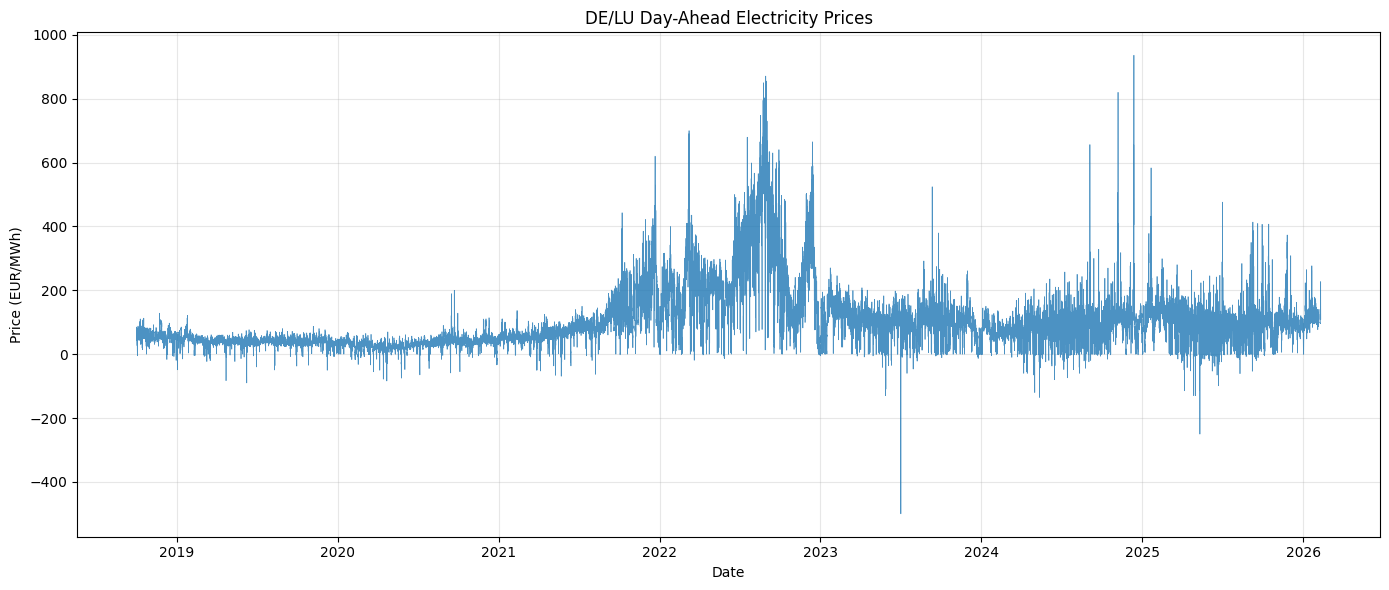

In [3]:
# Time series plot of electricity prices
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df["PRICE_DE_LU"], linewidth=0.5, alpha=0.8)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR/MWh)")
ax.set_title("DE/LU Day-Ahead Electricity Prices")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

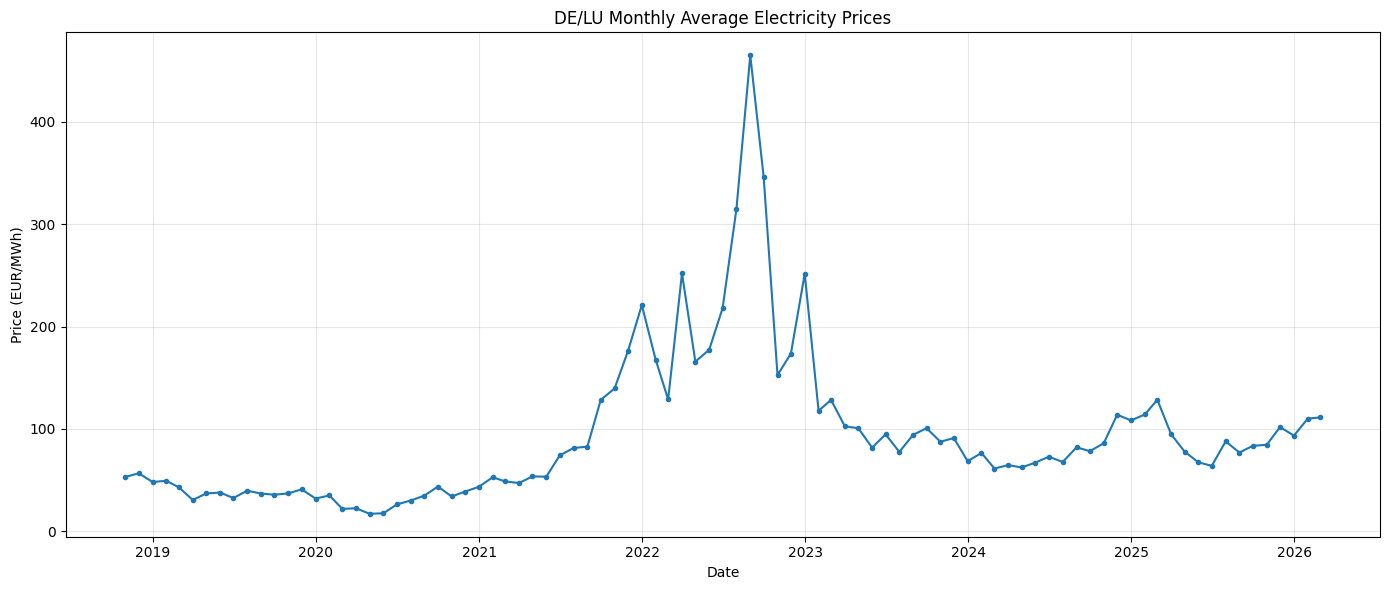

In [4]:
# Monthly average prices
monthly_avg = df.resample("ME").mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly_avg.index, monthly_avg["PRICE_DE_LU"], marker="o", markersize=3)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR/MWh)")
ax.set_title("DE/LU Monthly Average Electricity Prices")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Intraday Seasonality

The charts above use hourly resolution which compresses daily patterns. Below
we zoom into a three-week window so that the recurring daily and weekly price
cycles become clearly visible.

Typical patterns:

- **Morning ramp (06:00–09:00):** Prices rise sharply as households and
  industry come online.
- **Solar dip (11:00–15:00):** On sunny days, abundant solar generation
  pushes prices down around midday—sometimes below zero.
- **Evening peak (17:00–20:00):** Demand stays high while solar fades,
  forcing expensive gas plants onto the grid.
- **Weekend effect:** Lower industrial demand on Saturdays and Sundays
  compresses the entire price curve downward.

In [5]:
from datetime import datetime, timedelta

# Pick a recent 3-week window ending at the last full day in the hourly data
end_date = df.index.max().normalize()
start_date = end_date - timedelta(weeks=3)

sub_prices = df.loc[start_date:end_date].copy()
print(f"Hourly prices: {start_date.date()} to {end_date.date()} ({len(sub_prices)} records)")

Hourly prices: 2026-01-19 to 2026-02-09 (433 records)


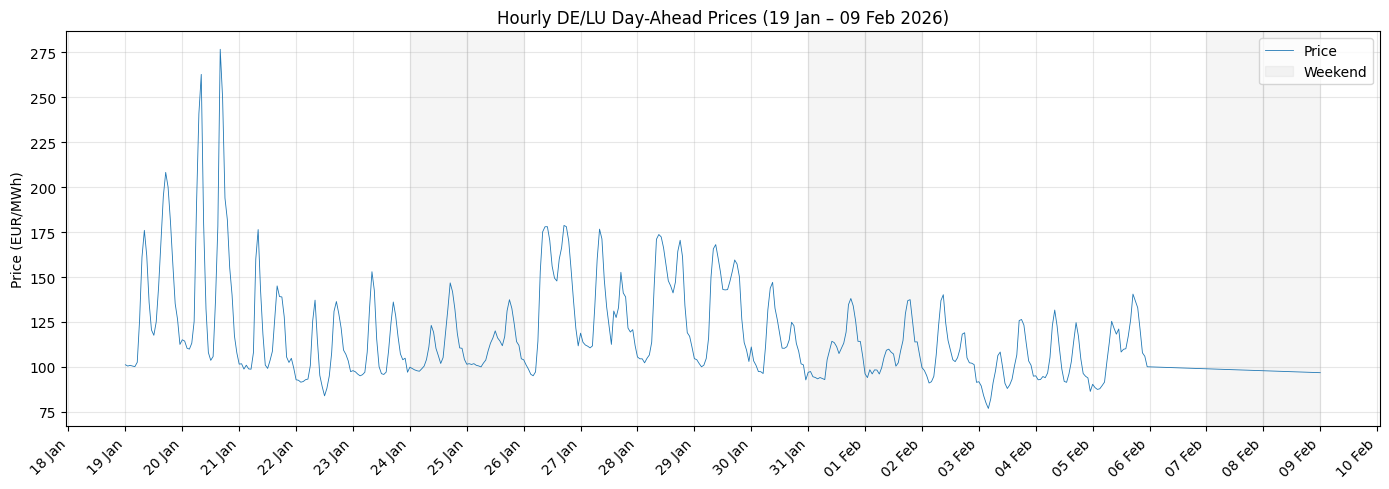

In [6]:
fig, ax = plt.subplots(figsize=(14, 5))

import matplotlib.dates as mdates

ax.plot(sub_prices.index, sub_prices["PRICE_DE_LU"], linewidth=0.6)
ax.set_ylabel("Price (EUR/MWh)")
ax.set_title(
    f"Hourly DE/LU Day-Ahead Prices "
    f"({start_date.strftime('%d %b')} – {end_date.strftime('%d %b %Y')})"
)
ax.grid(True, alpha=0.3)

# Show every day on the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
fig.autofmt_xdate(rotation=45)

# Shade weekends
for dt in pd.date_range(start_date, end_date, freq="D"):
    if dt.weekday() >= 5:  # Saturday=5, Sunday=6
        ax.axvspan(dt, dt + timedelta(days=1), alpha=0.08, color="grey")

ax.legend(["Price", "Weekend"], loc="upper right")
fig.tight_layout()
plt.show()

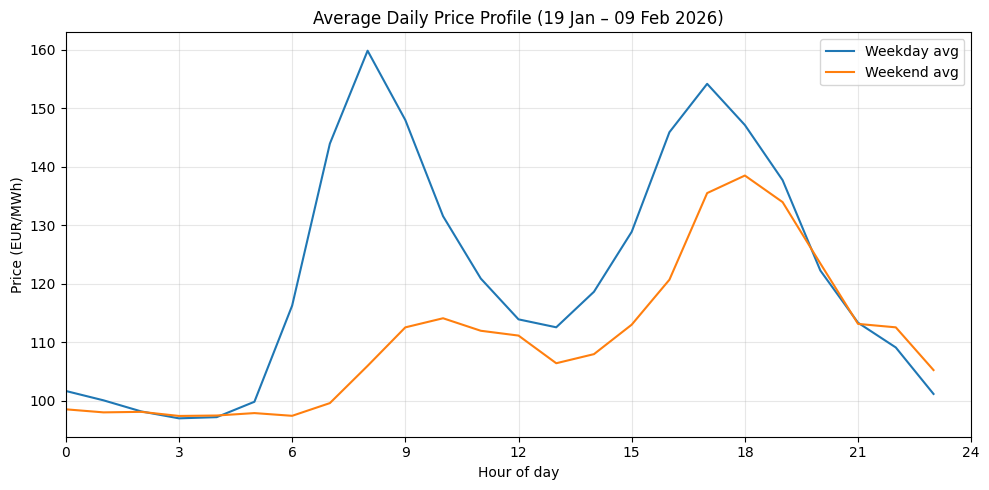

In [7]:
# Average daily profile across the 3-week window
sub_prices["hour"] = sub_prices.index.hour + sub_prices.index.minute / 60
sub_prices["is_weekend"] = sub_prices.index.weekday >= 5

weekday_profile = sub_prices[~sub_prices["is_weekend"]].groupby("hour")["PRICE_DE_LU"].mean()
weekend_profile = sub_prices[sub_prices["is_weekend"]].groupby("hour")["PRICE_DE_LU"].mean()

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(weekday_profile.index, weekday_profile.values, label="Weekday avg", linewidth=1.5)
ax.plot(weekend_profile.index, weekend_profile.values, label="Weekend avg", linewidth=1.5)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Price (EUR/MWh)")
ax.set_title(
    f"Average Daily Price Profile "
    f"({start_date.strftime('%d %b')} – {end_date.strftime('%d %b %Y')})"
)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 25, 3))
ax.legend()
ax.grid(True, alpha=0.3)

# Clean up helper columns
sub_prices.drop(columns=["hour", "is_weekend"], inplace=True)

fig.tight_layout()
plt.show()

## Electricity Prices and Natural Gas

In European electricity markets, **natural gas plants** frequently set the
marginal (price-setting) price because they sit at the expensive end of the
merit order. When gas prices rise, the cost of running these plants increases,
which lifts the clearing price for *all* generators—even low-cost renewables.

The chart below overlays monthly average electricity prices with the TTF
(Title Transfer Facility) natural gas front-month futures price. TTF is the
benchmark hub for north-west European gas trading and the most liquid gas
contract on the continent.

The tight co-movement during 2021-2023 illustrates how the gas supply crisis
directly transmitted into record electricity prices.

In [8]:
# Load TTF gas prices
gas_df = pd.read_parquet(paths.ttf_gas_prices_file)
gas_df.index = pd.to_datetime(gas_df.index)

print(f"Gas prices: {len(gas_df)} records")
print(f"Date range: {gas_df.index.min().date()} to {gas_df.index.max().date()}")

Gas prices: 2086 records
Date range: 2017-10-23 to 2026-02-06


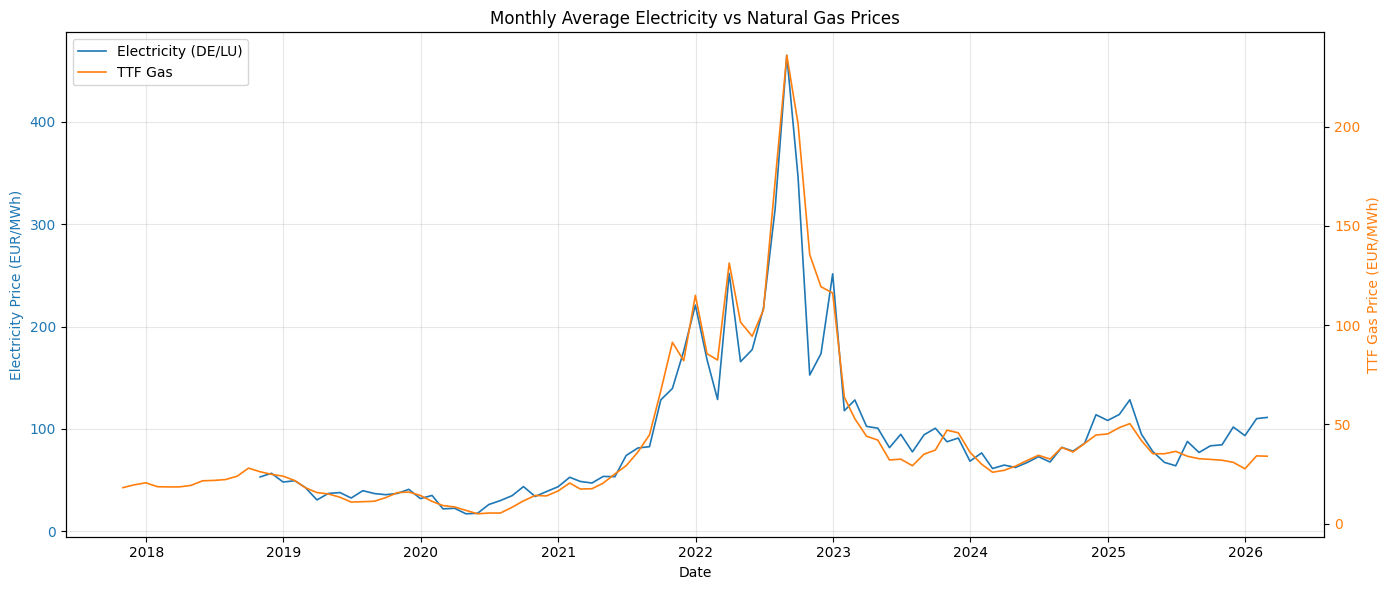

In [9]:
# Monthly averages for both series
monthly_power = df.resample("ME").mean()
monthly_gas = gas_df["Close"].resample("ME").mean()

fig, ax1 = plt.subplots(figsize=(14, 6))

color_power = "tab:blue"
ax1.plot(monthly_power.index, monthly_power["PRICE_DE_LU"],
         color=color_power, linewidth=1.2, label="Electricity (DE/LU)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Electricity Price (EUR/MWh)", color=color_power)
ax1.tick_params(axis="y", labelcolor=color_power)

ax2 = ax1.twinx()
color_gas = "tab:orange"
ax2.plot(monthly_gas.index, monthly_gas.values,
         color=color_gas, linewidth=1.2, label="TTF Gas")
ax2.set_ylabel("TTF Gas Price (EUR/MWh)", color=color_gas)
ax2.tick_params(axis="y", labelcolor=color_gas)

ax1.set_title("Monthly Average Electricity vs Natural Gas Prices")
ax1.grid(True, alpha=0.3)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

fig.tight_layout()
plt.show()

## Renewable Generation and Residual Load

**Residual load** is the electricity demand that must be covered by
dispatchable (controllable) power plants *after* subtracting variable
renewable generation:

$$\text{Residual Load} = \text{Total Load} - \text{Solar}
  - \text{Wind Onshore} - \text{Wind Offshore}$$

It is the single most important driver of wholesale electricity prices:

- **High residual load** → more conventional plants must run, including
  expensive gas turbines → **higher prices**
- **Low / negative residual load** → renewables cover (or exceed) demand →
  cheap plants suffice → **lower prices** (sometimes negative)

The stacked area chart below shows renewable generation (solar, onshore wind,
offshore wind) against total electricity load. The gap between the top of the
renewables stack and the load line *is* the residual load.

In [10]:
# Load generation and load data
solar = pd.read_parquet(paths.smard_solar_file)
wind_on = pd.read_parquet(paths.smard_wind_onshore_file)
wind_off = pd.read_parquet(paths.smard_wind_offshore_file)
total_load = pd.read_parquet(paths.smard_total_load_file)

# Combine into one DataFrame
gen = pd.concat([
    solar.rename(columns={solar.columns[0]: "solar"}),
    wind_on.rename(columns={wind_on.columns[0]: "wind_onshore"}),
    wind_off.rename(columns={wind_off.columns[0]: "wind_offshore"}),
    total_load.rename(columns={total_load.columns[0]: "total_load"}),
], axis=1).dropna()

gen["renewables"] = gen["solar"] + gen["wind_onshore"] + gen["wind_offshore"]
gen["residual_load"] = gen["total_load"] - gen["renewables"]

print(f"Generation data: {len(gen)} records")
print(f"Date range: {gen.index.min()} to {gen.index.max()}")

Generation data: 64420 records


Date range: 2018-10-01 01:00:00 to 2026-02-05 13:00:00


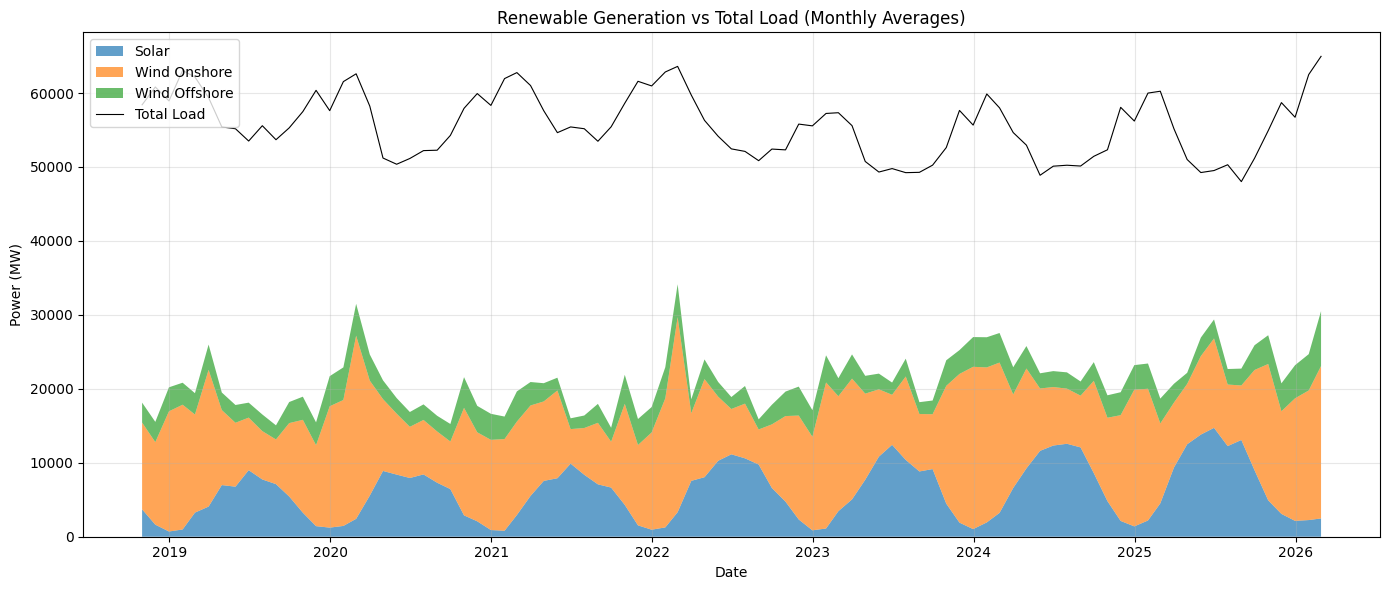

In [11]:
# Renewables vs total load (monthly averages for readability)
monthly_gen = gen.resample("ME").mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.stackplot(
    monthly_gen.index,
    monthly_gen["solar"],
    monthly_gen["wind_onshore"],
    monthly_gen["wind_offshore"],
    labels=["Solar", "Wind Onshore", "Wind Offshore"],
    alpha=0.7,
)
ax.plot(monthly_gen.index, monthly_gen["total_load"],
        color="black", linewidth=0.8, label="Total Load")

ax.set_xlabel("Date")
ax.set_ylabel("Power (MW)")
ax.set_title("Renewable Generation vs Total Load (Monthly Averages)")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

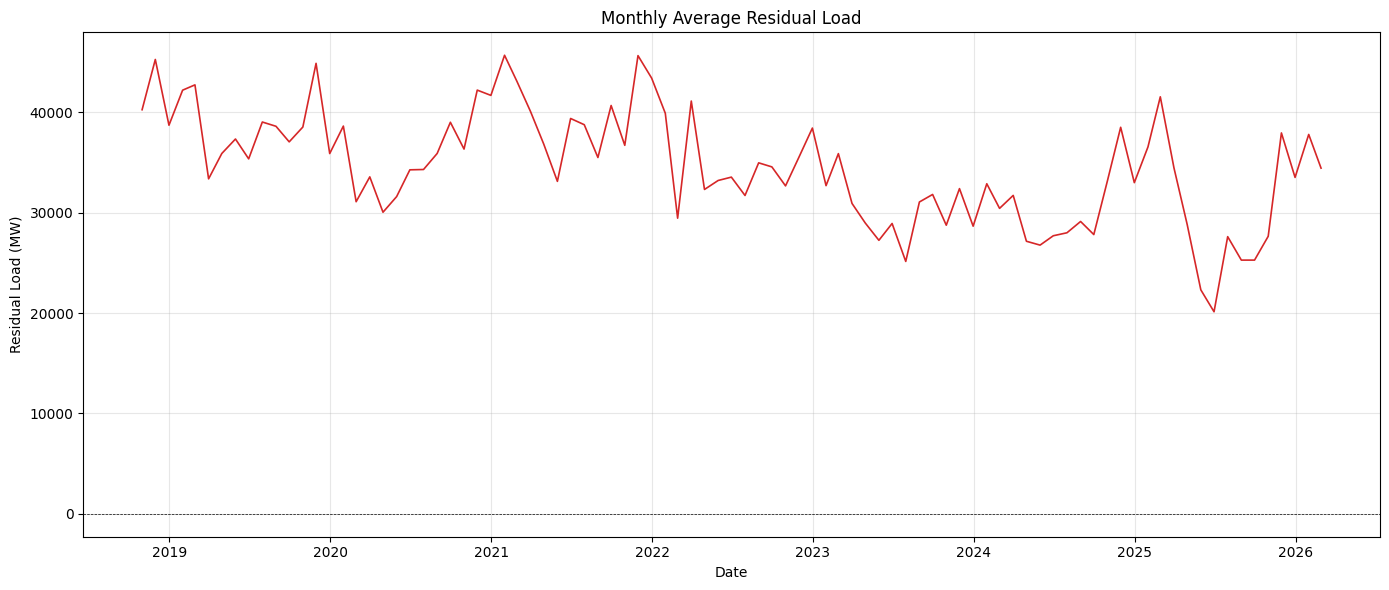

In [12]:
# Monthly average residual load
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly_gen.index, monthly_gen["residual_load"], color="tab:red", linewidth=1.2)
ax.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("Residual Load (MW)")
ax.set_title("Monthly Average Residual Load")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Residual Load vs Electricity Price

Because the merit order is roughly monotonic—cheap renewables first, then
coal/lignite, then gas—the price is largely determined by *how far up* the
supply curve demand reaches. Residual load measures exactly that.

The charts below zoom into three-week windows to show how hourly residual
load and electricity prices move together. A linear fit
(price = intercept + slope × residual load) is used to align the two
y-axes so that the visual overlap reflects the statistical relationship.

In [13]:
import numpy as np

# Align price and residual load on the same index
price_res = df[["PRICE_DE_LU"]].join(gen[["residual_load"]], how="inner").dropna()


def plot_price_vs_residual(price_res_window, title_dates):
    """Plot price and residual load with axes aligned via a linear fit."""
    X = price_res_window["residual_load"].values
    y = price_res_window["PRICE_DE_LU"].values
    slope, intercept = np.polyfit(X, y, 1)
    print(f"Linear fit: price = {intercept:.2f} + {slope:.4f} × residual_load")

    fig, ax1 = plt.subplots(figsize=(14, 6))

    color1 = "tab:blue"
    ax1.plot(price_res_window.index, price_res_window["residual_load"],
             color=color1, linewidth=0.5, alpha=0.7, label="Residual Load")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Residual Load (MW)", color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = "tab:orange"
    ax2.plot(price_res_window.index, price_res_window["PRICE_DE_LU"],
             color=color2, linewidth=0.5, alpha=0.7, label="Price")
    ax2.set_ylabel("Price (EUR/MWh)", color=color2)
    ax2.tick_params(axis="y", labelcolor=color2)

    # Align the residual load axis to the price axis using the linear fit
    p_lo, p_hi = ax2.get_ylim()
    ax1.set_ylim((p_lo - intercept) / slope, (p_hi - intercept) / slope)

    ax1.set_title(f"Residual Load and Electricity Price ({title_dates})")
    ax1.grid(True, alpha=0.3)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    fig.tight_layout()
    plt.show()

Matched records: 422
Linear fit: price = 26.08 + 0.0023 × residual_load


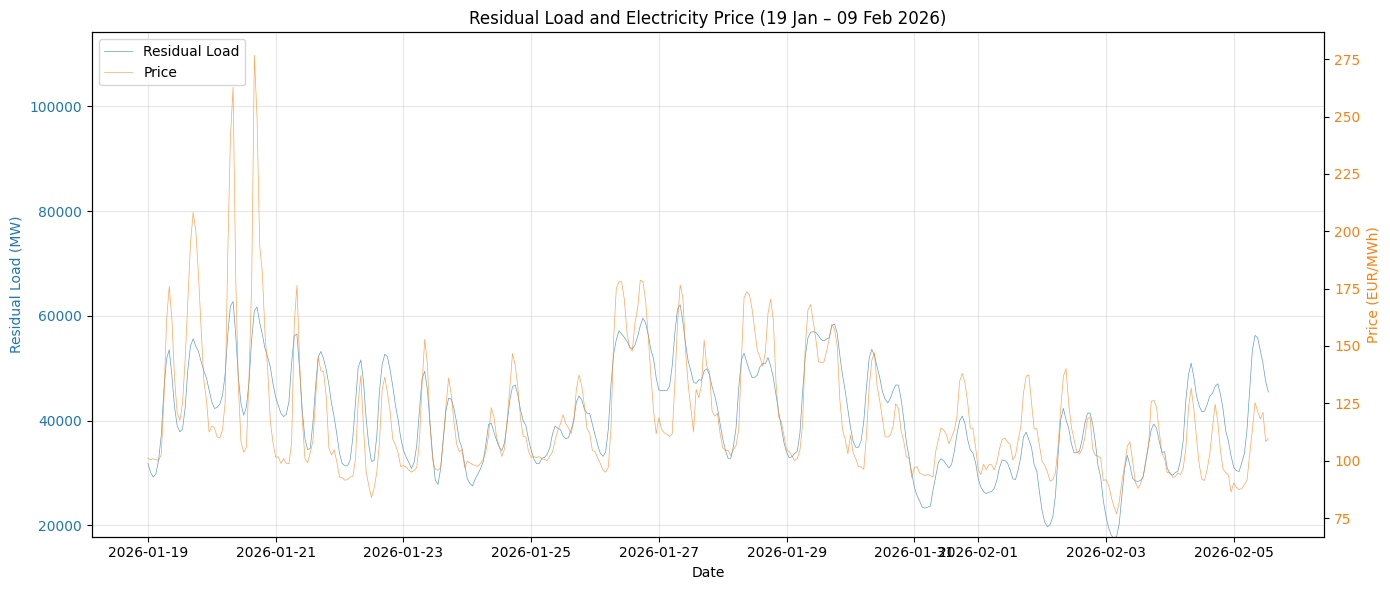

In [14]:
# Recent 3-week window (same as intraday section above)
price_res_sub = price_res.loc[start_date:end_date]
print(f"Matched records: {len(price_res_sub)}")

plot_price_vs_residual(
    price_res_sub,
    f"{start_date.strftime('%d %b')} – {end_date.strftime('%d %b %Y')}",
)

Matched records (2025 window): 505
Linear fit: price = -11.72 + 0.0036 × residual_load


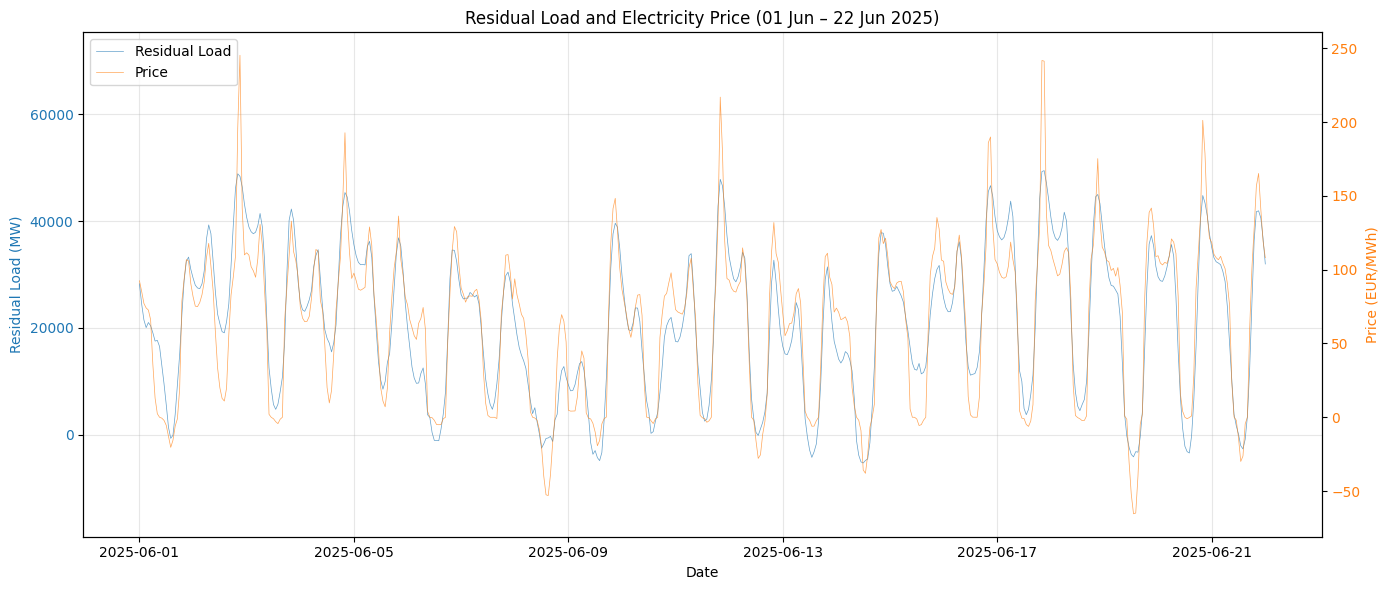

In [15]:
# A second 3-week window in 2025 for comparison
start_2025 = pd.Timestamp("2025-06-01")
end_2025 = start_2025 + timedelta(weeks=3)

price_res_2025 = price_res.loc[start_2025:end_2025]
print(f"Matched records (2025 window): {len(price_res_2025)}")

plot_price_vs_residual(
    price_res_2025,
    f"{start_2025.strftime('%d %b')} – {end_2025.strftime('%d %b %Y')}",
)

In [16]:
from IPython.display import Markdown

Markdown(f"Last run: {datetime.now().strftime('%Y-%m-%d')}")

Last run: 2026-02-08